In [14]:
from datetime import datetime
import os
import sys

from   keras.layers.recurrent import LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from   pandas.plotting import register_matplotlib_converters
import seaborn as sns
from   sklearn.metrics import r2_score 
from   sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from   tensorflow.keras.callbacks import ModelCheckpoint
from   tensorflow.keras.layers import Dense, Dropout, Input
from   tensorflow.keras.models import load_model, Model
from   tensorflow.keras.optimizers import SGD

register_matplotlib_converters()
%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA = '../../../data'

In [3]:
df = pd.read_csv(f'{DATA}/beijingAirPollution.csv')
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [4]:
dt = []
for _, (year, month, day, hour) in df[
        ['year', 'month', 'day', 'hour']].iterrows():
    dt.append(datetime(year=year, month=month, day=day, hour=hour))

In [5]:
df['datetime'] = dt
df.sort_values('datetime', inplace=True)
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,datetime
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0,2010-01-01 00:00:00
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0,2010-01-01 01:00:00
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0,2010-01-01 02:00:00
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0,2010-01-01 03:00:00
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0,2010-01-01 04:00:00


In [6]:
# NO! Scaling should be based on training data only, test data scaled
# accordingly
scaler = MinMaxScaler(feature_range=(0, 1))
df['scaled_PRES'] = scaler.fit_transform(
    np.array(df.PRES).reshape(-1, 1))

In [7]:
split_date = datetime(year=2014, month=1, day=1, hour=0)
df_train = df.loc[df['datetime'] < split_date]
df_val = df.loc[df['datetime'] >= split_date]
df_train.shape, df_val.shape

((35064, 15), (8760, 15))

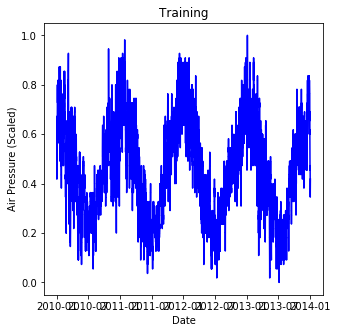

In [8]:
plt.figure(figsize=(5, 5))
g = sns.lineplot(df_train['datetime'], df_train.scaled_PRES, color='b')
g.set_title('Training')
g.set_xlabel('Date')
g.set_ylabel('Air Pressure (Scaled)');

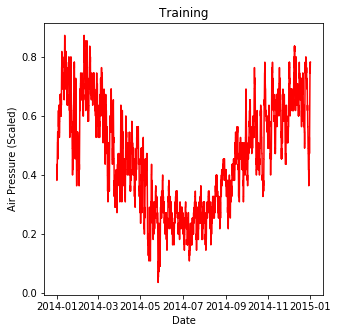

In [9]:
plt.figure(figsize=(5, 5))
g = sns.lineplot(df_val['datetime'], df_val.scaled_PRES, color='r')
g.set_title('Training')
g.set_xlabel('Date')
g.set_ylabel('Air Pressure (Scaled)');

In [10]:
def make_xy(ts, n_timesteps):
    ts.index = range(ts.shape[0])
    X = []
    y = []
    for i in range(n_timesteps, ts.shape[0]):
        X.append(list(ts.loc[i - n_timesteps:i - 1]))
        y.append(ts.loc[i])
    X, y = np.array(X), np.array(y)
    return X, y

In [11]:
X_train, y_train = make_xy(df_train['scaled_PRES'], 7)

In [12]:
X_val, y_val = make_xy(df_val.scaled_PRES, 7)
for d in [X_train, y_train, X_val, y_val]:
    print(d.shape)

(35057, 7)
(35057,)
(8753, 7)
(8753,)


In [13]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
for d in [X_train, y_train, X_val, y_val]:
    print(d.shape)

(35057, 7, 1)
(35057,)
(8753, 7, 1)
(8753,)
